In [1]:
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.decomposition import TruncatedSVD ,NMF
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import scattertext as st
from gensim import corpora, models, similarities, matutils
from collections import defaultdict
import csv
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier, RandomForestRegressor , ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift , KMeans
from sklearn.preprocessing import StandardScaler
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter
from spacy.symbols import amod
from pprint import pprint
import pandas as pd
import pickle
from nltk.tokenize import TreebankWordTokenizer
import json
from autocorrect import Speller
spell = Speller(lang='en')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading Datasets
#### the datasets from Yelp in json format

In [2]:
data_file = open("../Dataset/yelp_academic_dataset_review.json")
data = []
for line in data_file:
    data.append(json.loads(line))
reviews_df = pd.DataFrame(data)
data_file.close()

In [3]:
data_file = open("../Dataset/yelp_academic_dataset_business.json")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [4]:
reviews_df.head()

review_id                 user_id             business_id  \
0  lWC-xP3rd6obsecCYsGZRg  ak0TdVmGKo4pwqdJSTLwWw  buF9druCkbuXLX526sGELQ   
1  8bFej1QE5LXp4O05qjGqXA  YoVfDbnISlW0f7abNQACIg  RA4V8pr014UyUbDvI-LW2A   
2  NDhkzczKjLshODbqDoNLSg  eC5evKn1TWDyHCyQAwguUw  _sS2LBIGNT5NQb6PD1Vtjw   
3  T5fAqjjFooT4V0OeZyuk1w  SFQ1jcnGguO0LYWnbbftAA  0AzLzHfOJgL7ROwhdww2ew   
4  sjm_uUcQVxab_EeLCqsYLg  0kA0PAJ8QFMeveQWHFqz2A  8zehGz9jnxPqXtOc7KaJxA   

   stars  useful  funny  cool  \
0    4.0       3      1     1   
1    4.0       1      0     0   
2    5.0       0      0     0   
3    2.0       1      1     1   
4    4.0       0      0     0   

                                                text                 date  
0  Apparently Prides Osteria had a rough summer a...  2014-10-11 03:34:02  
1  This store is pretty good. Not as great as Wal...  2015-07-03 20:38:25  
2  I called WVM on the recommendation of a couple...  2013-05-28 20:38:06  
3  I've stayed at many Marriott and Renaissance M...  2010-01-08 02:29:15  
4  The food is always great here. The service fro...  2011-07-28 18:05:01

In [5]:
business_df.head()

business_id                     name              address  \
0  6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom         921 Pearl St   
1  tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX  7000 NE Airport Way   
2  bvN78flM8NLprQ1a1y5dRg           The Reclaimory   4720 Hawthorne Ave   
3  oaepsyvc0J17qwi8cfrOWg              Great Clips   2566 Enterprise Rd   
4  PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus  1046 Memorial Dr SE   

          city state postal_code   latitude   longitude  stars  review_count  \
0      Boulder    CO       80302  40.017544 -105.283348    4.0            86   
1     Portland    OR       97218  45.588906 -122.593331    4.0           126   
2     Portland    OR       97214  45.511907 -122.613693    4.5            13   
3  Orange City    FL       32763  28.914482  -81.295979    3.0             8   
4      Atlanta    GA       30316  33.747027  -84.353424    4.0            14   

   is_open                                         attributes  \
0        1  {'RestaurantsTableService': 'True', 'WiFi': 'u...   
1        1  {'RestaurantsTakeOut': 'True', 'RestaurantsAtt...   
2        1  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
3        1  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
4        1  {'GoodForKids': 'False', 'BusinessParking': '{...   

                                          categories  \
0  Gastropubs, Food, Beer Gardens, Restaurants, B...   
1  Salad, Soup, Sandwiches, Delis, Restaurants, C...   
2  Antiques, Fashion, Used, Vintage & Consignment...   
3                         Beauty & Spas, Hair Salons   
4  Gyms, Active Life, Interval Training Gyms, Fit...   

                                               hours  
0  {'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...  
1  {'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...  
2  {'Thursday': '11:0-18:0', 'Friday': '11:0-18:0...  
3                                               None  
4  {'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'...

#### dropping unwanted columns

In [6]:
business_df_droped=business_df.drop(['address','postal_code','latitude','longitude','stars','is_open','hours','attributes'], axis=1)

In [7]:
#merging the two datasets
dfall = pd.merge(reviews_df, business_df_droped)

In [8]:
#data we will use
data= dfall.sample(15000,random_state=199)

#### save the data using pickle

In [9]:
data.to_pickle("./data.pkl")

In [10]:
with open('../Dataset/data.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [11]:
data.head()

review_id                 user_id             business_id  \
0  lWC-xP3rd6obsecCYsGZRg  ak0TdVmGKo4pwqdJSTLwWw  buF9druCkbuXLX526sGELQ   
1  hpcZLEzqD4_gPi6eSVi_Bg  Y-j2svl0M_5-jF1ehYuNPQ  buF9druCkbuXLX526sGELQ   
2  3FvY1Se8y2WXqTbaANOqMw  xUCX4GhBpeWxZB0l2lmt_w  buF9druCkbuXLX526sGELQ   
3  C1uQNP2ehBktS43ZRMEvkg  2M6KFsWIUXElqcQRz4A0Qg  buF9druCkbuXLX526sGELQ   
4  Cja8_35_kQDnF9g4voikzw  t5SRIRU6INiAyVkiMJhRPA  buF9druCkbuXLX526sGELQ   

   stars  useful  funny  cool  \
0    4.0       3      1     1   
1    2.0       1      1     1   
2    5.0       3      0     0   
3    5.0       1      2     0   
4    1.0       0      0     0   

                                                text                 date  \
0  Apparently Prides Osteria had a rough summer a...  2014-10-11 03:34:02   
1  I was really disappointed to say the least. I ...  2014-11-30 00:24:42   
2  This is as close to dining in Italy as you'll ...  2014-04-19 16:48:28   
3  Great food and service! Again. 4 out of the la...  2014-09-10 00:06:00   
4  We ordered the roasted chicken and homemade pa...  2014-08-24 23:53:23   

             name     city state  review_count  \
0  Prides Osteria  Beverly    MA            83   
1  Prides Osteria  Beverly    MA            83   
2  Prides Osteria  Beverly    MA            83   
3  Prides Osteria  Beverly    MA            83   
4  Prides Osteria  Beverly    MA            83   

                                          categories  
0  Restaurants, Wine Bars, Nightlife, Farmers Mar...  
1  Restaurants, Wine Bars, Nightlife, Farmers Mar...  
2  Restaurants, Wine Bars, Nightlife, Farmers Mar...  
3  Restaurants, Wine Bars, Nightlife, Farmers Mar...  
4  Restaurants, Wine Bars, Nightlife, Farmers Mar...

### EDA
#### for first graph its shows Top 10 cities by businesses

In [12]:
city_business_counts = data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)

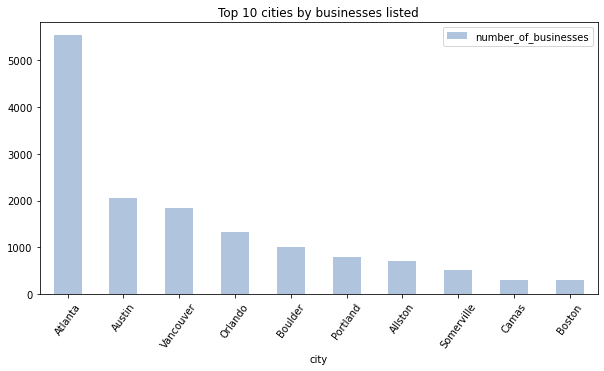

In [13]:
city_business_counts = pd.DataFrame(data=city_business_counts)
city_business_counts.rename(columns={'business_id' : 'number_of_businesses'}, inplace=True)

city_business_counts[0:10].sort_values(ascending=False, by="number_of_businesses")\
.plot(kind='bar', stacked=False, figsize=[10,5], color ='lightsteelblue')
plt.title('Top 10 cities by businesses listed')
plt.xticks(rotation=54);

In [14]:
city_business_reviews = data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

review_count     stars
city                               
Atlanta           6534719  3.709275
Portland          1832441  4.272383
Austin            1581464  3.859086
Vancouver         1071403  3.954397
Boulder            985793  4.280476
Orlando            503460  3.242630
Allston            503334  3.829847
Somerville         255488  3.371094
Camas               94848  3.983974
Winter Park         35530  4.347368

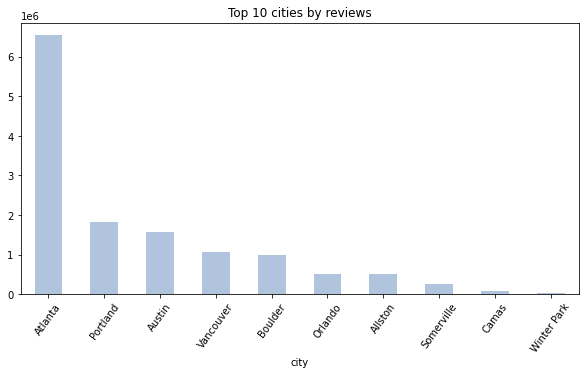

In [15]:
city_business_reviews['review_count'][0:10].plot(kind='bar', stacked=False, figsize=[10,5], \
                                                 color ='lightsteelblue')
plt.title('Top 10 cities by reviews')
plt.xticks(rotation=54);

for the above graph it shows which city has the most reviews

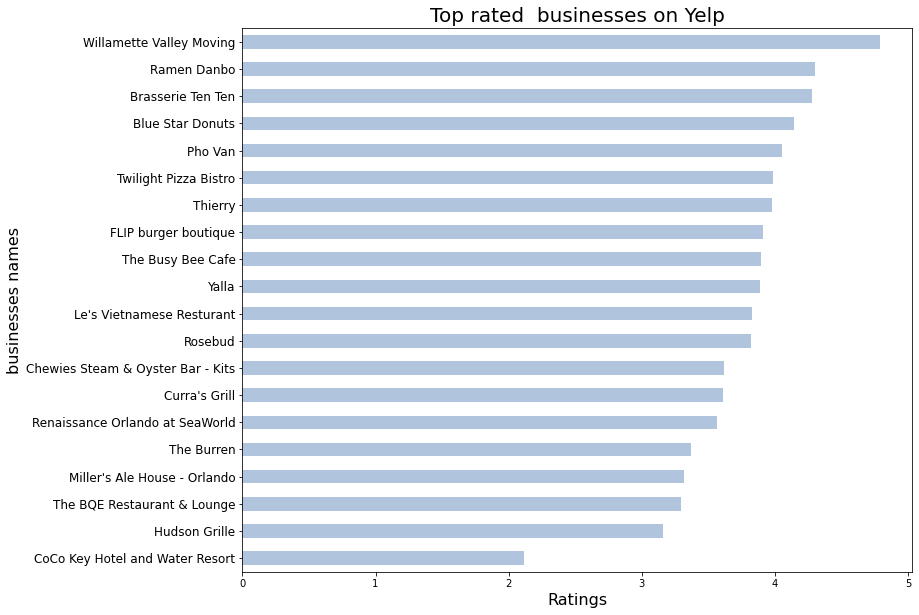

In [16]:
#inefficient if we take all of the business name

top_businesses = data.name.value_counts().index[:20].tolist()

df_review_top = data.loc[data['name'].isin(top_businesses)]

df_review_top.groupby(data.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10),color ='lightsteelblue')

plt.yticks(fontsize=12)

plt.title('Top rated  businesses on Yelp',fontsize=20)

plt.ylabel('businesses names', fontsize=16)

plt.xlabel('Ratings', fontsize=16)

plt.show()

this graph shows top 20 businesses by rating

### Data Cleaning

In [17]:
# make Sentiment only negative and positive , 1,2 for negarive  , 4,5 for positive
data = data[data.stars!=3]

data['Sentiment'] = np.where(data['stars'] >= 4, 'positive', 'negative')
data

review_id                 user_id             business_id  \
0      lWC-xP3rd6obsecCYsGZRg  ak0TdVmGKo4pwqdJSTLwWw  buF9druCkbuXLX526sGELQ   
1      hpcZLEzqD4_gPi6eSVi_Bg  Y-j2svl0M_5-jF1ehYuNPQ  buF9druCkbuXLX526sGELQ   
2      3FvY1Se8y2WXqTbaANOqMw  xUCX4GhBpeWxZB0l2lmt_w  buF9druCkbuXLX526sGELQ   
3      C1uQNP2ehBktS43ZRMEvkg  2M6KFsWIUXElqcQRz4A0Qg  buF9druCkbuXLX526sGELQ   
4      Cja8_35_kQDnF9g4voikzw  t5SRIRU6INiAyVkiMJhRPA  buF9druCkbuXLX526sGELQ   
...                       ...                     ...                     ...   
14993  hNA2yO5C-IN1jAM57SRxUA  iJbdK5-7eInOs4q9uIIpzQ  H_RM2u1WWGU1HkKZrYq2Ow   
14994  sgqfZ2wQG5uubnpLXf0IbQ  H0t7lBNtyoBMqxYDC7Z1hA  H_RM2u1WWGU1HkKZrYq2Ow   
14995  hx4axrn89gMxJWahSB07Yw  HylGr2mRKE9CCC9KvdvCoQ  H_RM2u1WWGU1HkKZrYq2Ow   
14998  g0smnB87GLUqMM-rPUXfJw  oWKJjpPR1JSzfLbxnB6baA  H_RM2u1WWGU1HkKZrYq2Ow   
14999  M8I6o9MsMnezsyGT4633lg  HksMj2RBkQmaDTLaYML3BQ  H_RM2u1WWGU1HkKZrYq2Ow   

       stars  useful  funny  cool  \
0        4.0       3      1     1   
1        2.0       1      1     1   
2        5.0       3      0     0   
3        5.0       1      2     0   
4        1.0       0      0     0   
...      ...     ...    ...   ...   
14993    5.0       0      0     0   
14994    5.0       0      0     0   
14995    5.0       0      0     0   
14998    1.0       1      1     1   
14999    5.0       1      1     1   

                                                    text                 date  \
0      Apparently Prides Osteria had a rough summer a...  2014-10-11 03:34:02   
1      I was really disappointed to say the least. I ...  2014-11-30 00:24:42   
2      This is as close to dining in Italy as you'll ...  2014-04-19 16:48:28   
3      Great food and service! Again. 4 out of the la...  2014-09-10 00:06:00   
4      We ordered the roasted chicken and homemade pa...  2014-08-24 23:53:23   
...                                                  ...                  ...   
14993  The best doughnuts I've ever had, hands down! ...  2016-02-01 16:48:32   
14994  Popped by Blue Star on a Saturday morning afte...  2014-08-11 21:57:41   
14995  Heart eyes.\n\nI was not thrilled with the wai...  2016-04-14 02:34:48   
14998  Healthier than regular donuts but wayyyyy less...  2018-07-28 21:12:04   
14999  1500+ reviews! I'll cut to the chase and tell ...  2016-04-01 22:32:22   

                   name      city state  review_count  \
0        Prides Osteria   Beverly    MA            83   
1        Prides Osteria   Beverly    MA            83   
2        Prides Osteria   Beverly    MA            83   
3        Prides Osteria   Beverly    MA            83   
4        Prides Osteria   Beverly    MA            83   
...                 ...       ...   ...           ...   
14993  Blue Star Donuts  Portland    OR          4011   
14994  Blue Star Donuts  Portland    OR          4011   
14995  Blue Star Donuts  Portland    OR          4011   
14998  Blue Star Donuts  Portland    OR          4011   
14999  Blue Star Donuts  Portland    OR          4011   

                                              categories Sentiment  
0      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive  
1      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative  
2      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive  
3      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive  
4      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative  
...                                                  ...       ...  
14993  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive  
14994  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive  
14995  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive  
14998  Coffee & Tea, Bakeries, Restaurants, Food, Don...  negative  
14999  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive  

[12984 rows x 15 columns]

In [18]:
# take only english words
data = data[data['text'].map(lambda x: x.isascii())]

In [20]:
# spell checking
data['text'] = data['text'].map(lambda x: spell(x))

In [21]:
# it takes long time so we save it in pickle
data.to_pickle("./data_after_spell.pkl")

In [22]:
with open('../Dataset/data_after_spell.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [23]:
#check for alphanumeric , punctuation and repeated characteristics and remove thim
alphanumeric=lambda x: re.sub('\w*\d\w*','',x)
punc_lower=lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x.lower())

repeated_chars = lambda x: re.sub('(.)\1{2,}', '\1', x)


data['text']=data.text.map(alphanumeric).map(punc_lower).map(repeated_chars)

In [24]:
# cleaning function

ENGLISH_STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

def my_tokenizer(sentence):
    
    
    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    listof_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            for punctuation_mark in string.punctuation:
                word = word.replace(punctuation_mark, '')
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

In [25]:
cleaned_text = data.text

In [26]:
#adding costum stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','large','order','les'
                                           ,'like','best','nice','love','pretty','extra', 'minutes','long','soft'
                                           ,'delicious', 'amazing','come','went','raven','definitely','friendly'
                                           ,'austin','boston','burgers','experience', 'people', 'better','make', 'favorite'
                                            , 'price','going','place','think','room','wait','way','know'
                                           ,'say','right','wanted','wasnt','took','told','left','asked','said'
                                           ,'small','little','want','youre','lot','big','quite','probably','maybe'
                                            ,'bit','novella','flip','tried','thierry','ordered','pho','sure'
                                           ,'help', 'awesome', 'excellent', 'perfect','recommend','risky','vancouver'
                                            ,'wonderful', 'use', 'used','willamette','bad','actually','things','isip'
                                            ,'spring', 'usually', 'new','fast','run','moving','getting', 'taking','hotel'
                                           ,'thats','thing','away','eat','looked','times','need','fact','thought'
                                            ,'look','doesnt','isnt','yes','walk','finally','let','waiting','walked','tell'
                                            ,'gave','check','later','feel','id','trying','oh','kind','looking','star','comes'
                                            ,'old','theres','different','home','ill','high','theyre','hard','mind',
                                            'mean','years', 'pay', 'money','called','pad','needed'
                                            ,'actresses','similar','relatively','pleasant','ow','opinion','impressed',
                                            'husbands','aside','wanting','unlike','treats','strange','st','sort','smooth'])

In [27]:
# define TF-IDF vectorizer
Tf_vectorizer = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words = stop_words).fit(cleaned_text)
text_tf = Tf_vectorizer.transform(cleaned_text)


In [28]:
# define Count vectorizer
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(cleaned_text)
text_cv = C_vectorizer.transform(cleaned_text)

### Topic Modeling

#### For topic modeling we will use LSA , NMF , Corex with Count vectorizer or TF-IDF and compare them.


#### LSA Count Vectorizer

In [29]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(text_cv)
lsa.explained_variance_ratio_

array([0.02761596, 0.0186875 , 0.01330096, 0.01182765, 0.01062772,
       0.01004551])

In [30]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["1","2",'3','4','5','6'],
             columns = C_vectorizer.get_feature_names())
topic_word

able  absolutely  accommodating    add  added  addition  additional  \
1  0.039       0.037          0.008  0.022  0.024     0.011       0.009   
2 -0.031      -0.019         -0.008 -0.003 -0.000    -0.002      -0.004   
3 -0.005       0.019         -0.000  0.008  0.013     0.004      -0.003   
4 -0.030      -0.010         -0.001  0.014  0.011     0.002      -0.005   
5  0.008       0.014          0.003  0.020  0.004     0.005       0.005   
6 -0.004       0.013         -0.001  0.001 -0.009    -0.002      -0.001   

   affordable  afternoon    ago  ...  write  writers  writes  wrong   yeah  \
1       0.006      0.016  0.023  ...  0.011    0.010   0.010  0.034  0.011   
2      -0.002     -0.004 -0.014  ... -0.006   -0.007  -0.006 -0.020 -0.002   
3       0.004      0.005 -0.002  ... -0.000   -0.004   0.002  0.001  0.004   
4       0.003     -0.009 -0.003  ...  0.004    0.003   0.016  0.003 -0.000   
5       0.005     -0.006  0.006  ...  0.002   -0.004  -0.003 -0.008 -0.003   
6      -0.002      0.002  0.007  ...  0.004    0.010   0.008  0.018 -0.005   

    year  youll  young  youve    yum  
1  0.021  0.021  0.014  0.010  0.009  
2 -0.014 -0.004 -0.014  0.000  0.004  
3  0.004  0.009 -0.010  0.005  0.012  
4 -0.019  0.005 -0.014  0.000  0.006  
5  0.016  0.005  0.010  0.009 -0.001  
6 -0.004 -0.006  0.000 -0.004 -0.004  

[6 rows x 860 columns]

In [31]:
def display_topics(model , feature_names, no_top_words, topic_names = None):
    for ix , topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic: ", ix)
        else:
            print('\nTopic: "',topic_names[ix],'"')
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, C_vectorizer.get_feature_names(), 20)


Topic:  0
chicken, fried, restaurant, menu, table, cheese, bar, sweet, night, staff, sauce, server, meal, drinks, fries, drink, dinner, branch, taste, busy

Topic:  1
chicken, fried, cheese, sweet, mac, sauce, busy, bee, rice, atlanta, dish, sides, greens, pork, southern, meat, flavor, soul, crisp, taste

Topic:  2
chocolate, debuts, sweet, taste, cake, flavor, macron, fries, coffee, blue, shake, sauce, flavors, fresh, milkshake, beef, onion, dessert, tasty, line

Topic:  3
restaurant, menu, dish, sauce, fries, table, branch, server, meal, beef, pork, fish, onion, shake, shrimp, dinner, milkshake, dishes, cheese, meat

Topic:  4
restaurant, water, dish, staff, noodles, pork, broth, park, rice, pool, rooms, bowl, sauce, fish, line, area, stay, kids, clean, resort

Topic:  5
restaurant, chocolate, table, debuts, cake, reservation, branch, macron, coffee, chicken, line, dish, waited, hour, party, manager, server, dessert, waitress, seated


#### LSA TF-IDF

In [32]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(text_tf)
lsa.explained_variance_ratio_

array([0.0037961 , 0.00885249, 0.00778817, 0.00695276, 0.00647485,
       0.00611237])

In [33]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["first","second",'third','fourth','fifth','sixth'],
             columns = Tf_vectorizer.get_feature_names())
topic_word

able  absolutely  accommodating    add  added  addition  additional  \
first   0.039       0.052          0.015  0.024  0.024     0.012       0.011   
second -0.024      -0.021         -0.013 -0.003  0.002    -0.003      -0.003   
third  -0.002       0.007         -0.005  0.014  0.007     0.001      -0.002   
fourth -0.015      -0.001         -0.007  0.036  0.029     0.003      -0.000   
fifth  -0.018      -0.011         -0.002 -0.015 -0.009    -0.002      -0.007   
sixth  -0.023       0.006         -0.004 -0.009 -0.003     0.004      -0.004   

        affordable  afternoon    ago  ...  write  writers  writes  wrong  \
first        0.015      0.021  0.029  ...  0.015    0.013   0.018  0.039   
second      -0.001     -0.001 -0.018  ... -0.005   -0.005  -0.009 -0.010   
third       -0.001      0.005 -0.000  ... -0.002    0.003  -0.012  0.000   
fourth       0.010     -0.012 -0.003  ...  0.007   -0.005   0.014  0.007   
fifth       -0.011      0.000 -0.013  ... -0.005   -0.001   0.008 -0.003   
sixth        0.006      0.004 -0.008  ... -0.001   -0.003   0.042  0.003   

         yeah   year  youll  young  youve    yum  
first   0.015  0.026  0.025  0.015  0.013  0.018  
second -0.003 -0.020 -0.007 -0.010 -0.001  0.009  
third   0.005 -0.001  0.002 -0.009  0.004  0.016  
fourth  0.006 -0.008  0.006 -0.008  0.002  0.018  
fifth   0.006 -0.011 -0.004 -0.005 -0.001  0.005  
sixth  -0.001 -0.015  0.005 -0.009 -0.001  0.009  

[6 rows x 860 columns]

In [34]:
display_topics(lsa, Tf_vectorizer.get_feature_names(), 20)


Topic:  0
chicken, fried, restaurant, menu, staff, night, bar, cheese, table, sweet, drinks, branch, fries, atmosphere, server, meal, dinner, hour, busy, worth

Topic:  1
chicken, fried, cheese, mac, atlanta, greens, sweet, soul, bee, busy, southern, wales, dams, sides, collar, n, rice, potato, velvet, sauce

Topic:  2
debuts, chocolate, coffee, macron, cake, sweet, blue, flavors, voodoo, line, taste, portland, fresh, desserts, broth, worth, pastries, blueberry, flavor, dessert

Topic:  3
broth, noodles, soup, pork, beef, sauce, bowl, rolls, vietnamese, menu, fries, noodle, restaurant, meat, avocado, rice, fresh, lunch, onion, currys

Topic:  4
fries, sweet, milkshake, potato, ots, shake, onion, rings, chocolate, bar, atmosphere, shakes, milkshakes, marshmallow, free, drinks, turkey, server, sides, fun

Topic:  5
chocolate, branch, macron, happy, coffee, hour, cake, dessert, currys, desserts, avocado, boulder, margaret, french, dinner, salsa, pastries, mexican, menu, ticos


### NMF
#### NMF Count Vectrizor

In [35]:
nmf_model_cv = NMF(6)
nmf_doc_topic = nmf_model_cv.fit_transform(text_cv)

topic_word = pd.DataFrame(nmf_model_cv.components_.round(3),
            index = ["1","2",'3','4','5','6'],
             columns = C_vectorizer.get_feature_names())

display_topics(nmf_model_cv , C_vectorizer.get_feature_names(),20)


Topic:  0
fries, menu, cheese, sweet, shake, onion, milkshake, potato, rings, free, ots, taste, beef, sauce, sides, tasty, fried, flavor, chef, marshmallow

Topic:  1
chicken, fried, cheese, busy, atlanta, mac, bee, sweet, greens, southern, soul, sides, wales, green, tea, red, potatoes, collar, ghits, meal

Topic:  2
chocolate, debuts, cake, macron, coffee, sweet, blue, taste, dessert, line, flavor, tart, flavors, desserts, cream, lemon, hot, quality, fresh, pastries

Topic:  3
water, staff, park, night, pool, area, rooms, stay, line, kids, clean, resort, parking, desk, open, work, fee, door, free, bed

Topic:  4
restaurant, dish, sauce, pork, noodles, broth, fish, rice, fresh, menu, bowl, meal, dishes, soup, meat, restaurants, dinner, vietnamese, shrimp, rolls

Topic:  5
table, bar, drinks, server, drink, waitress, reservation, branch, hour, manager, friends, party, seated, night, menu, sat, hostess, waited, music, friend


#### NMF TF-IDF

In [36]:
nmf_model_tf = NMF(6)
doc_topic = nmf_model_tf.fit_transform(text_tf)

topic_word = pd.DataFrame(nmf_model_tf.components_.round(3),
            index = ["first","second",'3','4','5','6'],
             columns = Tf_vectorizer.get_feature_names())

display_topics(nmf_model_tf , Tf_vectorizer.get_feature_names(),20)


Topic:  0
staff, bar, night, drinks, table, music, restaurant, friends, server, drink, manager, area, water, customer, atmosphere, work, parking, beer, location, waitress

Topic:  1
chicken, fried, cheese, mac, busy, atlanta, greens, soul, bee, wales, southern, dams, red, velvet, collar, n, sweet, sides, ghits, tea

Topic:  2
debuts, chocolate, cake, coffee, macron, blue, voodoo, flavors, portland, line, desserts, dessert, pastries, sweet, blueberry, lemon, worth, taste, tart, shop

Topic:  3
broth, noodles, soup, pork, rolls, vietnamese, bowl, fresh, sauce, avocado, currys, rice, noodle, restaurant, mexican, beef, salsa, meat, margaret, places

Topic:  4
fries, sweet, milkshake, shake, onion, rings, potato, ots, free, shakes, milkshakes, marshmallow, sides, menu, turkey, cheese, pickles, lunch, burnt, loved

Topic:  5
happy, hour, branch, menu, boulder, french, dinner, brasserie, wine, restaurant, reservation, writes, steak, oysters, ghits, mussels, prices, atmosphere, sunday, rosebu

### CorEx
#### CorEx count vectorizer

In [37]:
vectorizer = CountVectorizer(max_features=2000,
                            stop_words=stop_words,tokenizer=my_tokenizer,
                            binary=True)
doc_word = vectorizer.fit_transform(cleaned_text)
words = list(np.asarray(vectorizer.get_feature_names()))

In [38]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=cleaned_text)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sauce,flavor,taste,meat,broth,fresh,crisp,rice,pork,cooked
1: table,seated,bar,restaurant,server,tables,sat,night,waitress,party
2: fries,onion,potato,fried,rings,cheese,menu,ots,sweet,milkshake
3: manager,arrived,customer,car,desk,work,rude,phone,guys,received
4: rooms,pool,park,water,stay,resort,area,open,clean,kids
5: chicken,music,mac,greens,wales,velvet,busy,bee,irish,red


From above results we found Count vectorizer CorEx with 6 Topics are the best

#### CorEx TF-IDF

In [39]:
TFVectorizer = TfidfVectorizer(max_features=2000,
                            stop_words=stop_words,tokenizer=my_tokenizer,
                            binary=True)
doc_word = TFVectorizer.fit_transform(cleaned_text)
words = list(np.asarray(TFVectorizer.get_feature_names()))


In [40]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=cleaned_text)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: rooms,tire,movers,valley,procedure,lambs,resort,desk,pool,car
1: absolute,raised,pure,preferred,play,peak,passed,partner,par,pan
2: absolutely,piano,personally,parts,outside,ot,opening,opened,offers,offering
3: act,search,screens,regardless,recommendation,recent,range,rainy,priced,presented
4: ass,return,reminded,recommended,recalls,reason,point,plenty,pleased,piece
5: affordable,private,present,prepare,points,plan,parties,parents,packed,overpriced


### Naming Topics

In [41]:
topics_by_busniess = pd.DataFrame(nmf_doc_topic, columns = ['Food','NightLife','Food_Menu','Automotive','Hotel&Travel','ActiveLife'])
topics_by_busniess['main_topic'] = topics_by_busniess.idxmax(axis=1)
topics_by_busniess['text'] = data['text']

In [42]:
topics_by_busniess.dropna(inplace = True)
topics_by_busniess

Food  NightLife  Food_Menu  Automotive  Hotel&Travel  ActiveLife  \
1      0.019947   0.000000   0.000000    0.013628      0.022606    0.009820   
2      0.000000   0.000000   0.000000    0.000949      0.000000    0.001139   
3      0.000000   0.182382   0.007476    0.000000      0.018844    0.000000   
4      0.071442   0.000000   0.046941    0.005664      0.043720    0.065250   
5      0.000000   0.000000   0.000000    0.020061      0.000000    0.094709   
...         ...        ...        ...         ...           ...         ...   
12639  0.028755   0.000000   0.371243    0.000000      0.011651    0.000000   
12640  0.008513   0.000000   0.103466    0.045743      0.000000    0.001200   
12641  0.018332   0.000000   0.067162    0.014032      0.015126    0.006391   
12642  0.004105   0.000000   0.057823    0.000000      0.004107    0.000000   
12643  0.000000   0.000000   0.164099    0.001198      0.000000    0.011892   

         main_topic                                               text  
1      Hotel&Travel  i was really disappointed to say the least i s...  
2        ActiveLife  this is as close to dining in italy as youll f...  
3         NightLife  great food and service again  out of the last ...  
4              Food  we ordered the roasted chicken and homemade pa...  
5        ActiveLife  a gem tucked away in beverly the atmosphere is...  
...             ...                                                ...  
12639     Food_Menu  citizen kane knew what he was doing when his l...  
12640     Food_Menu  another place we researched pretty heavily bef...  
12641     Food_Menu  believe the reviews about the bad service here...  
12642     Food_Menu  what a disappointment  like every restaurant i...  
12643     Food_Menu  thanks to help i found out about rosebud  and ...  

[10651 rows x 8 columns]

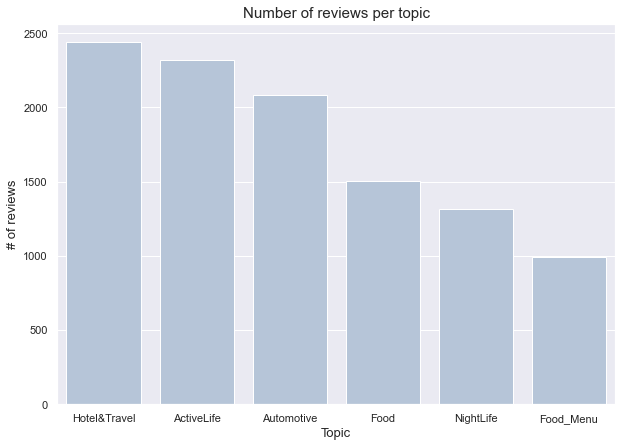

In [43]:
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="main_topic",data=topics_by_busniess,color='lightsteelblue', order = topics_by_busniess['main_topic'].value_counts().index );
ax.set_xlabel("Topic",fontsize=13);
ax.set_ylabel("# of reviews",fontsize=13);
ax.set_title('Number of reviews per topic',fontsize=15);

the above graph shows the most reviews per topic

###  Clustering

In [44]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(text_cv)
    distortions.append(kmeanModel.inertia_)


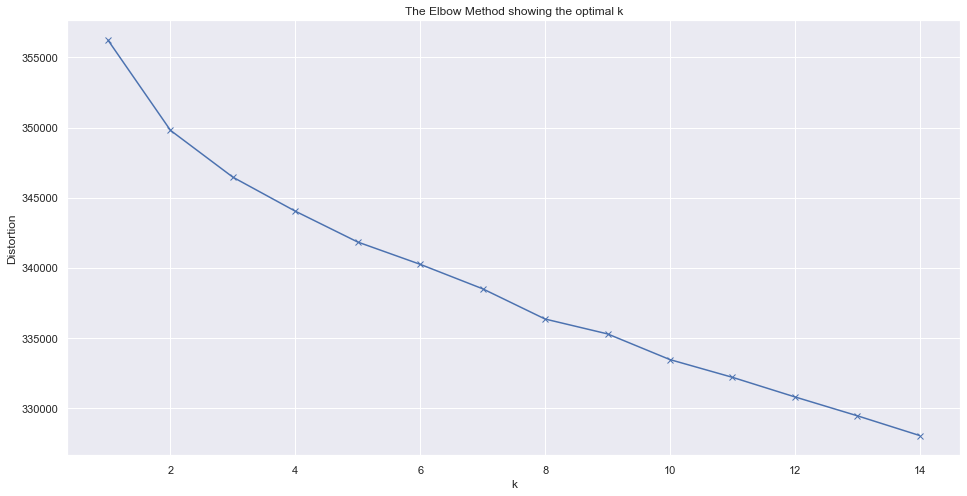

In [45]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [46]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(text_tf)
    distortions.append(kmeanModel.inertia_)

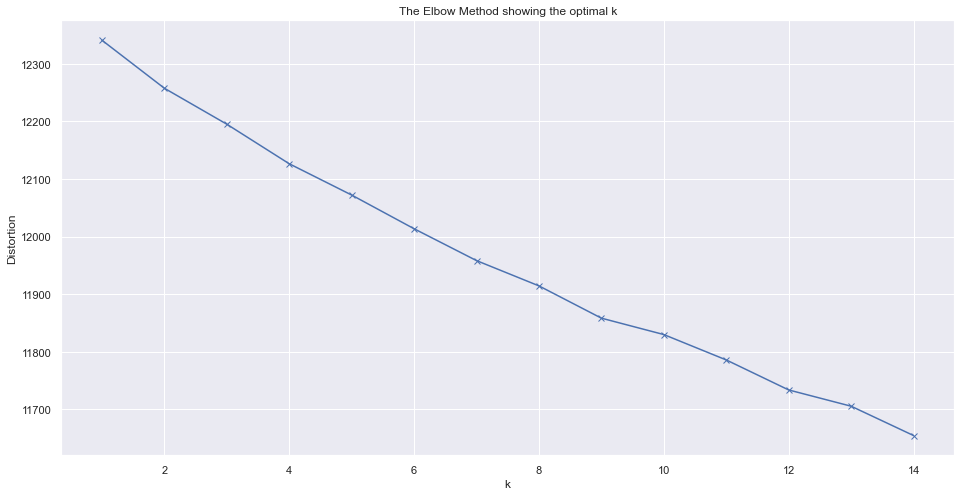

In [47]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

the elbow graphs tell us how many cluster we can use but here its note clear for us

In [48]:
vectorizer= CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
cv= vectorizer.fit_transform(cleaned_text.apply(lambda x: np.str_(x)))
cv.shape

km = KMeans(n_clusters=2,random_state=10)
cluster_labels=km.fit_predict(text_tf)
data['cluster']=cluster_labels

In [49]:
data['cluster'].value_counts()

1    11245
0     1399
Name: cluster, dtype: int64

In [50]:
vectorizer= CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
cv= vectorizer.fit_transform(cleaned_text.apply(lambda x: np.str_(x)))
cv.shape

km = KMeans(n_clusters=2,random_state=10)
cluster_labels=km.fit_predict(text_cv)
data['cluster']=cluster_labels

In [51]:
data['cluster'].value_counts()

1    10958
0     1686
Name: cluster, dtype: int64

### Recommendation Systems

#### Negative Recommendation system
for Negative Recommendation system we used simple metric and it gave us the similarities between negative rating

In [52]:
neg_data_rec = data.copy()

In [53]:
# make ratings only positive or negative

neg_data_rec = neg_data_rec[neg_data_rec.stars !=3]

neg_data_rec['Sentiment'] = np.where(neg_data_rec['stars'] >= 4, 'positive', 'negative')
neg_data_rec

review_id                 user_id             business_id  \
1      hpcZLEzqD4_gPi6eSVi_Bg  Y-j2svl0M_5-jF1ehYuNPQ  buF9druCkbuXLX526sGELQ   
2      3FvY1Se8y2WXqTbaANOqMw  xUCX4GhBpeWxZB0l2lmt_w  buF9druCkbuXLX526sGELQ   
3      C1uQNP2ehBktS43ZRMEvkg  2M6KFsWIUXElqcQRz4A0Qg  buF9druCkbuXLX526sGELQ   
4      Cja8_35_kQDnF9g4voikzw  t5SRIRU6INiAyVkiMJhRPA  buF9druCkbuXLX526sGELQ   
5      iBd6WvCXER9aU6xfR8YtMA  Kgz8xohZN1r2e-qN5GQ2pQ  buF9druCkbuXLX526sGELQ   
...                       ...                     ...                     ...   
14993  hNA2yO5C-IN1jAM57SRxUA  iJbdK5-7eInOs4q9uIIpzQ  H_RM2u1WWGU1HkKZrYq2Ow   
14994  sgqfZ2wQG5uubnpLXf0IbQ  H0t7lBNtyoBMqxYDC7Z1hA  H_RM2u1WWGU1HkKZrYq2Ow   
14995  hx4axrn89gMxJWahSB07Yw  HylGr2mRKE9CCC9KvdvCoQ  H_RM2u1WWGU1HkKZrYq2Ow   
14998  g0smnB87GLUqMM-rPUXfJw  oWKJjpPR1JSzfLbxnB6baA  H_RM2u1WWGU1HkKZrYq2Ow   
14999  M8I6o9MsMnezsyGT4633lg  HksMj2RBkQmaDTLaYML3BQ  H_RM2u1WWGU1HkKZrYq2Ow   

       stars  useful  funny  cool  \
1        2.0       1      1     1   
2        5.0       3      0     0   
3        5.0       1      2     0   
4        1.0       0      0     0   
5        5.0       1      0     0   
...      ...     ...    ...   ...   
14993    5.0       0      0     0   
14994    5.0       0      0     0   
14995    5.0       0      0     0   
14998    1.0       1      1     1   
14999    5.0       1      1     1   

                                                    text                 date  \
1      i was really disappointed to say the least i s...  2014-11-30 00:24:42   
2      this is as close to dining in italy as youll f...  2014-04-19 16:48:28   
3      great food and service again  out of the last ...  2014-09-10 00:06:00   
4      we ordered the roasted chicken and homemade pa...  2014-08-24 23:53:23   
5      a gem tucked away in beverly the atmosphere is...  2013-09-04 15:26:06   
...                                                  ...                  ...   
14993  the best doughnut ive ever had hands down i am...  2016-02-01 16:48:32   
14994  topped by blue star on a saturday morning afte...  2014-08-11 21:57:41   
14995  heart eyes\n\ni was not thrilled with the wait...  2016-04-14 02:34:48   
14998  healthier than regular debuts but wayyyyy less...  2018-07-28 21:12:04   
14999   reviews ill cut to the chase and tell you tha...  2016-04-01 22:32:22   

                   name      city state  review_count  \
1        Prides Osteria   Beverly    MA            83   
2        Prides Osteria   Beverly    MA            83   
3        Prides Osteria   Beverly    MA            83   
4        Prides Osteria   Beverly    MA            83   
5        Prides Osteria   Beverly    MA            83   
...                 ...       ...   ...           ...   
14993  Blue Star Donuts  Portland    OR          4011   
14994  Blue Star Donuts  Portland    OR          4011   
14995  Blue Star Donuts  Portland    OR          4011   
14998  Blue Star Donuts  Portland    OR          4011   
14999  Blue Star Donuts  Portland    OR          4011   

                                              categories Sentiment  cluster  
1      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative        0  
2      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive        1  
3      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive        1  
4      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative        1  
5      Restaurants, Wine Bars, Nightlife, Farmers Mar...  positive        1  
...                                                  ...       ...      ...  
14993  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive        1  
14994  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive        1  
14995  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive        1  
14998  Coffee & Tea, Bakeries, Restaurants, Food, Don...  negative        1  
14999  Coffee & Tea, Bakeries, Restaurants, Food, Don...  positive        1  

[12644 

In [54]:
#we want only negative ratings
neg_data_rec.Sentiment=np.where(~neg_data_rec.Sentiment.isin(['negative']), np.nan,neg_data_rec.Sentiment)

In [55]:
neg_data_rec

review_id                 user_id             business_id  \
1      hpcZLEzqD4_gPi6eSVi_Bg  Y-j2svl0M_5-jF1ehYuNPQ  buF9druCkbuXLX526sGELQ   
2      3FvY1Se8y2WXqTbaANOqMw  xUCX4GhBpeWxZB0l2lmt_w  buF9druCkbuXLX526sGELQ   
3      C1uQNP2ehBktS43ZRMEvkg  2M6KFsWIUXElqcQRz4A0Qg  buF9druCkbuXLX526sGELQ   
4      Cja8_35_kQDnF9g4voikzw  t5SRIRU6INiAyVkiMJhRPA  buF9druCkbuXLX526sGELQ   
5      iBd6WvCXER9aU6xfR8YtMA  Kgz8xohZN1r2e-qN5GQ2pQ  buF9druCkbuXLX526sGELQ   
...                       ...                     ...                     ...   
14993  hNA2yO5C-IN1jAM57SRxUA  iJbdK5-7eInOs4q9uIIpzQ  H_RM2u1WWGU1HkKZrYq2Ow   
14994  sgqfZ2wQG5uubnpLXf0IbQ  H0t7lBNtyoBMqxYDC7Z1hA  H_RM2u1WWGU1HkKZrYq2Ow   
14995  hx4axrn89gMxJWahSB07Yw  HylGr2mRKE9CCC9KvdvCoQ  H_RM2u1WWGU1HkKZrYq2Ow   
14998  g0smnB87GLUqMM-rPUXfJw  oWKJjpPR1JSzfLbxnB6baA  H_RM2u1WWGU1HkKZrYq2Ow   
14999  M8I6o9MsMnezsyGT4633lg  HksMj2RBkQmaDTLaYML3BQ  H_RM2u1WWGU1HkKZrYq2Ow   

       stars  useful  funny  cool  \
1        2.0       1      1     1   
2        5.0       3      0     0   
3        5.0       1      2     0   
4        1.0       0      0     0   
5        5.0       1      0     0   
...      ...     ...    ...   ...   
14993    5.0       0      0     0   
14994    5.0       0      0     0   
14995    5.0       0      0     0   
14998    1.0       1      1     1   
14999    5.0       1      1     1   

                                                    text                 date  \
1      i was really disappointed to say the least i s...  2014-11-30 00:24:42   
2      this is as close to dining in italy as youll f...  2014-04-19 16:48:28   
3      great food and service again  out of the last ...  2014-09-10 00:06:00   
4      we ordered the roasted chicken and homemade pa...  2014-08-24 23:53:23   
5      a gem tucked away in beverly the atmosphere is...  2013-09-04 15:26:06   
...                                                  ...                  ...   
14993  the best doughnut ive ever had hands down i am...  2016-02-01 16:48:32   
14994  topped by blue star on a saturday morning afte...  2014-08-11 21:57:41   
14995  heart eyes\n\ni was not thrilled with the wait...  2016-04-14 02:34:48   
14998  healthier than regular debuts but wayyyyy less...  2018-07-28 21:12:04   
14999   reviews ill cut to the chase and tell you tha...  2016-04-01 22:32:22   

                   name      city state  review_count  \
1        Prides Osteria   Beverly    MA            83   
2        Prides Osteria   Beverly    MA            83   
3        Prides Osteria   Beverly    MA            83   
4        Prides Osteria   Beverly    MA            83   
5        Prides Osteria   Beverly    MA            83   
...                 ...       ...   ...           ...   
14993  Blue Star Donuts  Portland    OR          4011   
14994  Blue Star Donuts  Portland    OR          4011   
14995  Blue Star Donuts  Portland    OR          4011   
14998  Blue Star Donuts  Portland    OR          4011   
14999  Blue Star Donuts  Portland    OR          4011   

                                              categories Sentiment  cluster  
1      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative        0  
2      Restaurants, Wine Bars, Nightlife, Farmers Mar...       NaN        1  
3      Restaurants, Wine Bars, Nightlife, Farmers Mar...       NaN        1  
4      Restaurants, Wine Bars, Nightlife, Farmers Mar...  negative        1  
5      Restaurants, Wine Bars, Nightlife, Farmers Mar...       NaN        1  
...                                                  ...       ...      ...  
14993  Coffee & Tea, Bakeries, Restaurants, Food, Don...       NaN        1  
14994  Coffee & Tea, Bakeries, Restaurants, Food, Don...       NaN        1  
14995  Coffee & Tea, Bakeries, Restaurants, Food, Don...       NaN        1  
14998  Coffee & Tea, Bakeries, Restaurants, Food, Don...  negative        1  
14999  Coffee & Tea, Bakeries, Restaurants, Food, Don...       NaN        1  

[12644 

In [56]:
neg_data_rec.dropna(inplace = True)

In [57]:
# drop unwanted colummns
neg_data_rec = neg_data_rec.drop(['useful','useful','review_id','funny','cool','text','date','city','state','review_count','categories','business_id','stars','Sentiment'],axis = 1)

In [58]:
neg_data_rec.head()

user_id            name  cluster
1   Y-j2svl0M_5-jF1ehYuNPQ  Prides Osteria        0
4   t5SRIRU6INiAyVkiMJhRPA  Prides Osteria        1
6   1kM4jg4O-tFrmuBBnb8wdA  Prides Osteria        1
14  7NuAk35FPwEZ1HwVIV5vsw  Prides Osteria        1
16  u1Y6J-Ef4Skn8sJ1TpAoaw  Prides Osteria        1

In [59]:
neg_data_rec = neg_data_rec.drop_duplicates()

In [60]:
# save the data to csv file
    
neg_data_rec = pd.DataFrame(neg_data_rec)
neg_data_rec.to_csv(r'neg_data_rec.csv', index=False)

In [61]:
user_resturant_map = defaultdict(list)
resturant_user_map = defaultdict(list)

In [62]:
with open('neg_data_rec.csv', 'r') as csvfile:
    w = csv.reader(csvfile, delimiter=',')
    for row in w:
        user_resturant_map[row[0]].append((row[1]))
        resturant_user_map[row[1]].append((row[0]))

In [63]:
user_resturant_map

defaultdict(list,
            {'user_id': ['name'],
             'Y-j2svl0M_5-jF1ehYuNPQ': ['Prides Osteria'],
             't5SRIRU6INiAyVkiMJhRPA': ['Prides Osteria'],
             '1kM4jg4O-tFrmuBBnb8wdA': ['Prides Osteria'],
             '7NuAk35FPwEZ1HwVIV5vsw': ['Prides Osteria'],
             'u1Y6J-Ef4Skn8sJ1TpAoaw': ['Prides Osteria'],
             'Pf4znQEWoL7DY1mntu2VeQ': ['Prides Osteria'],
             '8DtqS0yhbIKrJJNDyKo2Ig': ['Prides Osteria'],
             'ljvgd9ksG-q3ZY9loBwS6w': ['Prides Osteria'],
             'g35OBHqo6AnJNMHSfp6IQw': ['Prides Osteria'],
             'kAaoaiYkwzddLvOm4FVj1g': ['Prides Osteria'],
             'Oc56GrSA7DhuU95WIqiG4g': ['Prides Osteria'],
             'DIB4IaGdro00-pZI1Hz84w': ['Prides Osteria'],
             '8iuZoPo2CCOfkdpzPqlbJA': ['Prides Osteria'],
             'wvnwou32Tww-xf27yvFn2Q': ['Prides Osteria'],
             'Wm5UpzeAJez0tE64OL3ELA': ['Prides Osteria'],
             'sMRucNvjaoSrvo6Jo5yjhA': ['Prides Osteria'],
    

In [64]:
#show users that rate this restaurant
resturant_user_map['FLIP burger boutique']

['bAiFQACvrvt5ta_dbjSuGw',
 'F9f5_srXoQqY8lb6px8rRg',
 'w6V7H8jNfOBYpEg7b1gBWg',
 'vT_IVmYK6vsGih9lFMKGIQ',
 'P4nqCBSaZrHsC8jZ1RC7KQ',
 '_jhwIalGUDSADNShCentNA',
 '-PzBp3krvmNQPZuerP6suA',
 'j5zgvOExlgj5EI53tyC2lQ',
 'MJN9iey3zaI-oc8mfm_-aQ',
 'FPKDDZcwvBTHLk0rWhbbww',
 'Q0EI_CivJGpWwt5mTGziTg',
 'dQeOk5L1HaX3vjQrLifs2Q',
 'y0aS9Cbiuzmx7kEsiPzX6g',
 '0LJOF9YPt-nSDcBhPndjsA',
 'EhU7aWf24XQQYgRN-rW1gQ',
 'ZI43zlKUCjOVdEgcccs2bw',
 '71X9c1PQjHeLrC_oBsCXuQ',
 'o5E7vyVD8hvnxdZOrpBbKA',
 'SXEYMXbG7KC6Xn3O4UAleA',
 '4OwS_Ln3KC1acuYP-1upsg',
 'LWdALOgcuFvEVR23b-Snhg',
 'fkTKjgEtBAOM385qPPonLA',
 'WjcNX8QWRUI_ENHCz-x6tw',
 '9hSu3--CQzihJzCe96uIjA',
 'vMiEIlSpNihn0BXt2utRnQ',
 'r3BUY7FbchQkWw18TuVSSA',
 'xgNwLDQHtmHNpSxb2xEkqQ',
 'l3CipKqsSg_1mpoV8I9p8g',
 'eZoqpGzgT4WvsEmBkVTPPA',
 'JUFoMSntHDWom5UGqJa1-w',
 'uuSVZJW5E46dLIZCBaLuzQ',
 'ZDYWEBhEDCIFbeg_idm1cw',
 '32j5sYiDdJ1VoSyi-uat8A',
 'MzxRGKcDwYTUr3-z7eXq5g',
 'gtkJMWDfspFAnmX8ENPMtQ',
 'YyCSCMXnn2B1TbwAOg_87Q',
 'A_7Qp7LDdTThc0r6sk4c6Q',
 

In [65]:
# show what this user rated in business
user_resturant_map['2']

[]

In [66]:
def get_similar_resturant(user_resturant_map,resturant_user_map,m):
    biglist = []
    for u in resturant_user_map[m]: # get all users that liked this business
        biglist.extend(user_resturant_map[u]) # find all other business those users liked and add to biglist
    return Counter(biglist).most_common(4)[1:] # use counter to 'count' the other business that show up most common

In [67]:
def get_resturant_recommendation(user_resturant_map,resturant_user_map,u1):
    biglist = []
    for m in user_resturant_map[u1]: # for the business a specific user likes
        for u in resturant_user_map[m]: # get other users who liked those businesses
            biglist.extend(user_resturant_map[u]) # find the other businesses those "similar folks" most liked
    return Counter(biglist).most_common(3) # return tuples of (most common business, count)

In [68]:
get_similar_resturant(user_resturant_map,resturant_user_map,'FLIP burger boutique')

[('Rosebud', 1)]

In [69]:
get_resturant_recommendation(user_resturant_map,resturant_user_map,'F9f5_srXoQqY8lb6px8rRg')

[('FLIP burger boutique', 247), ('Rosebud', 1)]

#### Positive Recommendation system

In [70]:
pos_data_rec = data.copy()

In [71]:
pos_data_rec = pos_data_rec[pos_data_rec.stars!=3]

pos_data_rec['Sentiment'] = np.where(pos_data_rec['stars'] >= 4, 'positive', 'negative')

pos_data_rec.Sentiment=np.where(~pos_data_rec.Sentiment.isin(['positive']), np.nan,pos_data_rec.Sentiment)

pos_data_rec.dropna(inplace = True)

pos_data_rec = pos_data_rec.drop(['useful','useful','review_id','funny','cool','text','date','city','state','review_count','categories','business_id','stars','Sentiment'],axis = 1)

In [72]:
pos_data_rec

user_id              name  cluster
2      xUCX4GhBpeWxZB0l2lmt_w    Prides Osteria        1
3      2M6KFsWIUXElqcQRz4A0Qg    Prides Osteria        1
5      Kgz8xohZN1r2e-qN5GQ2pQ    Prides Osteria        1
8      l0gxisitVlPxXVQiIaEj7A    Prides Osteria        1
10     avQ84oaYIM0YTh2FkfSFzQ    Prides Osteria        0
...                       ...               ...      ...
14991  JucxNtTmQzCRbVZwnFADhg  Blue Star Donuts        1
14993  iJbdK5-7eInOs4q9uIIpzQ  Blue Star Donuts        1
14994  H0t7lBNtyoBMqxYDC7Z1hA  Blue Star Donuts        1
14995  HylGr2mRKE9CCC9KvdvCoQ  Blue Star Donuts        1
14999  HksMj2RBkQmaDTLaYML3BQ  Blue Star Donuts        1

[9939 rows x 3 columns]

In [73]:
pos_data_rec_dum=pd.get_dummies(pos_data_rec['name'])

In [74]:
pos_data_rec = pd.concat([pos_data_rec,pos_data_rec_dum],axis=1)

In [75]:
pos_data_rec

user_id              name  cluster  \
2      xUCX4GhBpeWxZB0l2lmt_w    Prides Osteria        1   
3      2M6KFsWIUXElqcQRz4A0Qg    Prides Osteria        1   
5      Kgz8xohZN1r2e-qN5GQ2pQ    Prides Osteria        1   
8      l0gxisitVlPxXVQiIaEj7A    Prides Osteria        1   
10     avQ84oaYIM0YTh2FkfSFzQ    Prides Osteria        0   
...                       ...               ...      ...   
14991  JucxNtTmQzCRbVZwnFADhg  Blue Star Donuts        1   
14993  iJbdK5-7eInOs4q9uIIpzQ  Blue Star Donuts        1   
14994  H0t7lBNtyoBMqxYDC7Z1hA  Blue Star Donuts        1   
14995  HylGr2mRKE9CCC9KvdvCoQ  Blue Star Donuts        1   
14999  HksMj2RBkQmaDTLaYML3BQ  Blue Star Donuts        1   

       Austin's BestLocksmith  Blue Star Donuts  Bolt Fabrics  \
2                           0                 0             0   
3                           0                 0             0   
5                           0                 0             0   
8                           0                 0             0   
10                          0                 0             0   
...                       ...               ...           ...   
14991                       0                 1             0   
14993                       0                 1             0   
14994                       0                 1             0   
14995                       0                 1             0   
14999                       0                 1             0   

       Boston Chowda Co  Brasserie Ten Ten  Chatham's Place  \
2                     0                  0                0   
3                     0                  0                0   
5                     0                  0                0   
8                     0                  0                0   
10                    0                  0                0   
...                 ...                ...              ...   
14991                 0                  0                0   
14993                 0                  0                0   
14994                 0                  0                0   
14995                 0                  0                0   
14999                 0                  0                0   

       Chevron - Extra Mile  ...  Sub-Base Sandwich Shoppe/Dandy Donuts  \
2                         0  ...                                      0   
3                         0  ...                                      0   
5                         0  ...                                      0   
8                         0  ...                                      0   
10                        0  ...                                      0   
...                     ...  ...                                    ...   
14991                     0  ...                                      0   
14993                     0  ...                                      0   
14994                     0  ...                                      0   
14995                     0  ...                                      0   
14999                     0  ...                                      0   

       Target  The BQE Restaurant & Lounge  The Burren  The Busy Bee Cafe  \
2           0                            0           0                  0   
3           0                            0           0                  0   
5           0                            0           0                  0   
8           0                            0           0                  0   
10          0                            0           0                  0   
...       ...                          ...         ...                ...   
14991       0                            0           0                  0   
14993       0                            0           0                  0   
14994       0                            0           0                  0   
14995       0                            0           0                  0   
14999       0  

In [76]:
pos_data_rec = pos_data_rec.drop(["name"], axis=1, errors="ignore")
pos_data_rec.head()

user_id  cluster  Austin's BestLocksmith  Blue Star Donuts  \
2   xUCX4GhBpeWxZB0l2lmt_w        1                       0                 0   
3   2M6KFsWIUXElqcQRz4A0Qg        1                       0                 0   
5   Kgz8xohZN1r2e-qN5GQ2pQ        1                       0                 0   
8   l0gxisitVlPxXVQiIaEj7A        1                       0                 0   
10  avQ84oaYIM0YTh2FkfSFzQ        0                       0                 0   

    Bolt Fabrics  Boston Chowda Co  Brasserie Ten Ten  Chatham's Place  \
2              0                 0                  0                0   
3              0                 0                  0                0   
5              0                 0                  0                0   
8              0                 0                  0                0   
10             0                 0                  0                0   

    Chevron - Extra Mile  Chewies Steam & Oyster Bar - Kits  ...  \
2                      0                                  0  ...   
3                      0                                  0  ...   
5                      0                                  0  ...   
8                      0                                  0  ...   
10                     0                                  0  ...   

    Sub-Base Sandwich Shoppe/Dandy Donuts  Target  \
2                                       0       0   
3                                       0       0   
5                                       0       0   
8                                       0       0   
10                                      0       0   

    The BQE Restaurant & Lounge  The Burren  The Busy Bee Cafe  \
2                             0           0                  0   
3                             0           0                  0   
5                             0           0                  0   
8                             0           0                  0   
10                            0           0                  0   

    The Storm Crow Tavern  Thierry  Twilight Pizza Bistro  \
2                       0        0                      0   
3                       0        0                      0   
5                       0        0                      0   
8                       0        0                      0   
10                      0        0                      0   

    Willamette Valley Moving  Yalla  
2                          0      0  
3                          0      0  
5                          0      0  
8                          0      0  
10                         0      0  

[5 rows x 45 columns]

In [77]:
pos_data_rec=pos_data_rec.drop_duplicates()

In [78]:
pos_data_rec.user_id.value_counts()

YSfAlm6XNaym-JOrRjv3Tg    4
246MeCEVYzuJQ-TtWi9y6g    3
KOVqZ1GEVMnQwqoWxugpSg    3
WoEfl5cpreTvMC5d_0UOMQ    3
D9IMOsV39BvoDNb08N9myQ    3
                         ..
uuHadP0FH8sIbCvmaGBURw    1
fO8ncTH1evKKmAId9jfVtA    1
6vGOfwVqy2hoI2P5fJuGkg    1
KePOWZxCwtACYexZ15rjJQ    1
VRWTjhJm7O-qzw1Pgqzc7Q    1
Name: user_id, Length: 9444, dtype: int64

In [79]:
pos_data_rec=pos_data_rec.groupby('user_id').sum()

In [80]:
pos_data_rec=pos_data_rec.reset_index()

pos_data_rec = pos_data_rec.drop(["user_id"], axis=1, errors="ignore")

In [81]:
pos_data_rec = pos_data_rec.rename(columns={"index": "user_id"})

In [82]:
pos_data_rec = pos_data_rec.reset_index()

In [83]:
pos_data_rec = pos_data_rec.rename(columns={"index": "user_id"})

In [84]:
pos_data_rec = pos_data_rec.set_index('user_id')

In [85]:
pos_data_rec

cluster  Austin's BestLocksmith  Blue Star Donuts  Bolt Fabrics  \
user_id                                                                    
0              1                       0                 0             0   
1              1                       0                 0             0   
2              1                       0                 0             0   
3              1                       0                 0             0   
4              1                       0                 1             0   
...          ...                     ...               ...           ...   
9439           1                       0                 0             0   
9440           1                       0                 0             0   
9441           1                       0                 0             0   
9442           1                       0                 0             0   
9443           1                       0                 0             0   

         Boston Chowda Co  Brasserie Ten Ten  Chatham's Place  \
user_id                                                         
0                       0                  0                0   
1                       0                  0                0   
2                       0                  0                0   
3                       0                  0                0   
4                       0                  0                0   
...                   ...                ...              ...   
9439                    0                  0                0   
9440                    0                  0                0   
9441                    0                  0                0   
9442                    0                  0                1   
9443                    0                  0                0   

         Chevron - Extra Mile  Chewies Steam & Oyster Bar - Kits  \
user_id                                                            
0                           0                                  0   
1                           0                                  0   
2                           0                                  0   
3                           0                                  0   
4                           0                                  0   
...                       ...                                ...   
9439                        0                                  0   
9440                        0                                  0   
9441                        0                                  0   
9442                        0                                  0   
9443                        0                                  0   

         CoCo Key Hotel and Water Resort  ...  \
user_id                                   ...   
0                                      0  ...   
1                                      0  ...   
2                                      0  ...   
3                                      0  ...   
4                                      0  ...   
...                                  ...  ...   
9439                                   0  ...   
9440                                   0  ...   
9441                                   0  ...   
9442                                   0  ...   
9443                                   0  ...   

         Sub-Base Sandwich Shoppe/Dandy Donuts  Target  \
user_id                                                  
0                                            0       0   
1                                            0       0   
2                                            0       0   
3                                            0       0   
4                                            0       0   
...                                        ...     ...   
9439                                         0       0   
9440                                         0       0   
9441                                         0       0   
9442         

### WordCloud

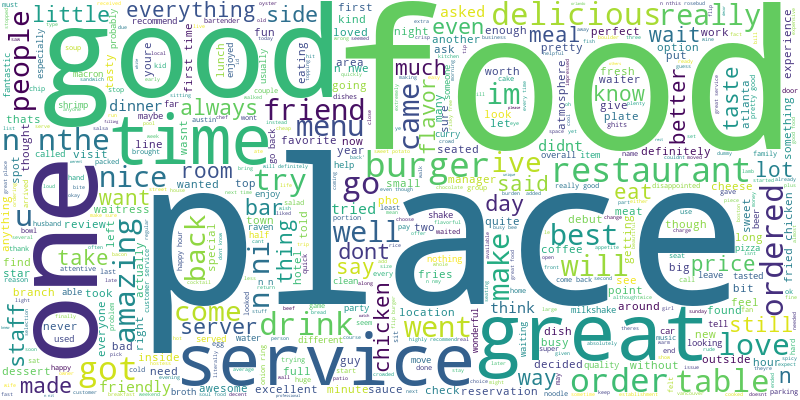

In [92]:
from wordcloud import WordCloud
texts = ' '.join(str(list(cleaned_text)).split())
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='blues', width=800, height=400)
wordcloud.generate(texts)
wordcloud.to_image()

here we have the most words that used in our data

### Classification models

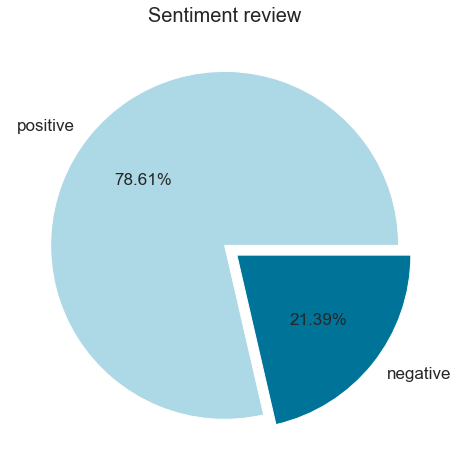

In [93]:
plt.figure(figsize=(8,8))
plt.pie(x=data['Sentiment'].value_counts(),labels=['positive','negative'],autopct='%.2f%%',textprops={'fontsize': 17},explode=[0,0.09],colors = ['#ADD8E6','#007399'])
plt.title('Sentiment review',fontdict={'fontsize':20})
plt.show()

our target seems unbalanced so we will try Logistic Regression to see if its enhance accuracy and f1-score

assign our target and columns then splitting the data

In [94]:
X = data.text
y = data.Sentiment

In [95]:
 data.Sentiment.unique()

array(['negative', 'positive'], dtype=object)

In [96]:
Xrem, X_train, yrem, y_train = train_test_split(X, y, test_size=0.9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(Xrem, yrem, test_size=0.5, random_state=42)


define Count Vectorizer and TF-IDF

In [97]:
Tf_vectorizer = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words = stop_words).fit(X_train)
X_train_tf = Tf_vectorizer.transform(X_train)
X_val1_tf = Tf_vectorizer.transform(X_val)
X_test_tf = Tf_vectorizer.transform(X_test)

In [98]:
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(X_train)
X_train_cv = C_vectorizer.transform(X_train)
X_val1_cv = C_vectorizer.transform(X_val)
X_test_cv = C_vectorizer.transform(X_test)

### Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr = LogisticRegression()

In [100]:
lr.fit(X_train_cv, y_train)
print('The accuracy for training : ',lr.score(X_train_cv,y_train))
print('The accuracy for validation: ',lr.score(X_val1_cv,y_val))

The accuracy for training :  0.9289103690685413
The accuracy for validation:  0.8813291139240507


In [101]:
lr.fit(X_train_tf, y_train)
print('The accuracy for training : ',lr.score(X_train_tf,y_train))
print('The accuracy for validation: ',lr.score(X_val1_tf,y_val))

The accuracy for training :  0.9133567662565905
The accuracy for validation:  0.8686708860759493


In [102]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

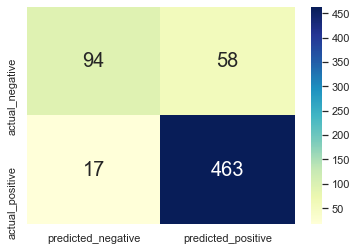

In [103]:
lr.fit(X_train_cv , y_train)
y_pred_cv1 = lr.predict(X_val1_cv)
cm1 = conf_matrix(y_val , y_pred_cv1)

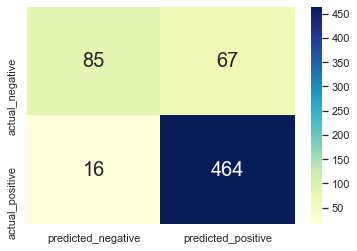

In [104]:
lr.fit(X_train_tf , y_train)
y_pred_tf1 = lr.predict(X_val1_tf)
cm2 = conf_matrix(y_val , y_pred_tf1)

### Weighted Logistic Regression

In [105]:
LR_CLF_2X = LogisticRegression(class_weight={"positive" : 1, "negative" : 3}, solver='liblinear')
LR_CLF_2X.fit(X_train_cv, y_train)
print('The accuracy for training : ',LR_CLF_2X.score(X_train_cv,y_train))
print('The accuracy for validation: ',LR_CLF_2X.score(X_val1_cv,y_val))

The accuracy for training :  0.9191564147627417
The accuracy for validation:  0.8718354430379747


In [106]:
LR_CLF_2X.fit(X_train_tf, y_train)
print('The accuracy for training : ',LR_CLF_2X.score(X_train_tf,y_train))
print('The accuracy for validation: ',LR_CLF_2X.score(X_val1_tf,y_val))

The accuracy for training :  0.9125659050966608
The accuracy for validation:  0.8765822784810127


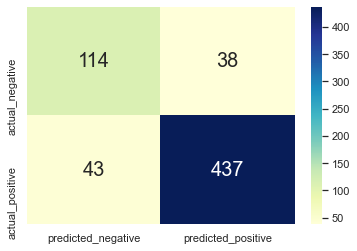

In [107]:
LR_CLF_2X.fit(X_train_cv , y_train)
y_pred_cv4 = LR_CLF_2X.predict(X_val1_cv)
cm7 = conf_matrix(y_val , y_pred_cv4)

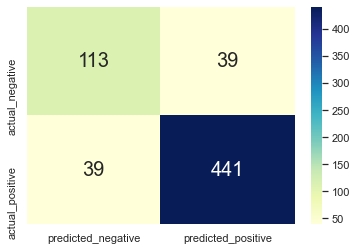

In [108]:
LR_CLF_2X.fit(X_train_tf , y_train)
y_pred_tf4 = LR_CLF_2X.predict(X_val1_tf)
cm8 = conf_matrix(y_val , y_pred_tf4)

Here wighted LogisticRegression didnt improve the accuracy and f1-score so its balanced data.

### Ada Boost



In [109]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=0)
AB_CLF.fit(X_train_cv , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train_cv,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val1_cv,y_val))


The accuracy for training :  0.8805799648506151
The accuracy for validation:  0.8370253164556962


In [110]:
AB_CLF.fit(X_train_tf , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train_tf,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val1_tf,y_val))

The accuracy for training :  0.8796133567662566
The accuracy for validation:  0.8433544303797469


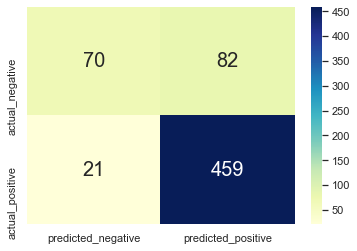

In [111]:
AB_CLF.fit(X_train_cv , y_train)
y_pred_cv5 = AB_CLF.predict(X_val1_cv)
cm9 = conf_matrix(y_val , y_pred_cv5)


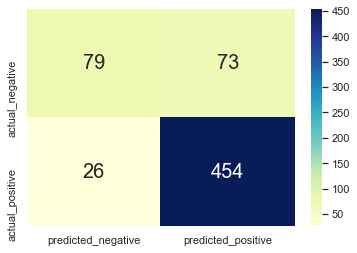

In [112]:
AB_CLF.fit(X_train_tf , y_train)
y_pred_tf5 = AB_CLF.predict(X_val1_tf)
cm10 = conf_matrix(y_val , y_pred_tf5)


here are the results that shows Accuracy , Precision , Recall and F1 Score for each model

#### Final Result (Logistic Regression)

In [113]:
X_train_val = pd.concat([X_train , X_val])
y_train_val = pd.concat([y_train , y_val])

In [114]:
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(X_train_val)
X_train_cvـ = C_vectorizer.transform(X_train_val)
X_test_cvـ = C_vectorizer.transform(X_test)

In [115]:
lr.fit(X_train_cvـ, y_train_val)
print('The accuracy for training and validation : ',lr.score(X_train_cvـ,y_train_val))
print('The accuracy for test: ',lr.score(X_test_cvـ,y_test))

The accuracy for training and validation :  0.9308191808191808
The accuracy for test:  0.8971518987341772


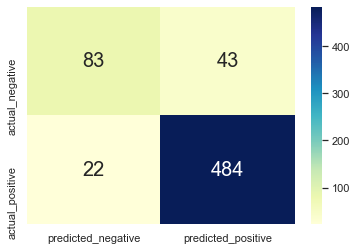

In [116]:
lr.fit(X_train_cvـ , y_train_val)
y_pred_test = lr.predict(X_test_cvـ)
cm0 = conf_matrix(y_test , y_pred_test)

### Conclusion

- Logistic regression was best model.
- For topics CorEx with count vectorizer was the best.
- Yelp reviews is more on Hotel&Travel.